In [191]:
!pip3 install tensorflow
!pip3 install kagglehub


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [192]:
import kagglehub
import os
import pandas as pd
import numpy as np

In [193]:
file_path = os.path.join("wre.us.txt")
df = pd.read_csv(file_path)

# Extraer encabezados
header = df.columns.tolist()
price = df["Close"].to_numpy()             
raw_data = df.iloc[:, 1:].to_numpy() 


# Punto 1
## Parsing Data



In [194]:
import numpy as np
price_high = df["High"].to_numpy()
price_low = df["Low"].to_numpy()
price = (price_high + price_low) / 2

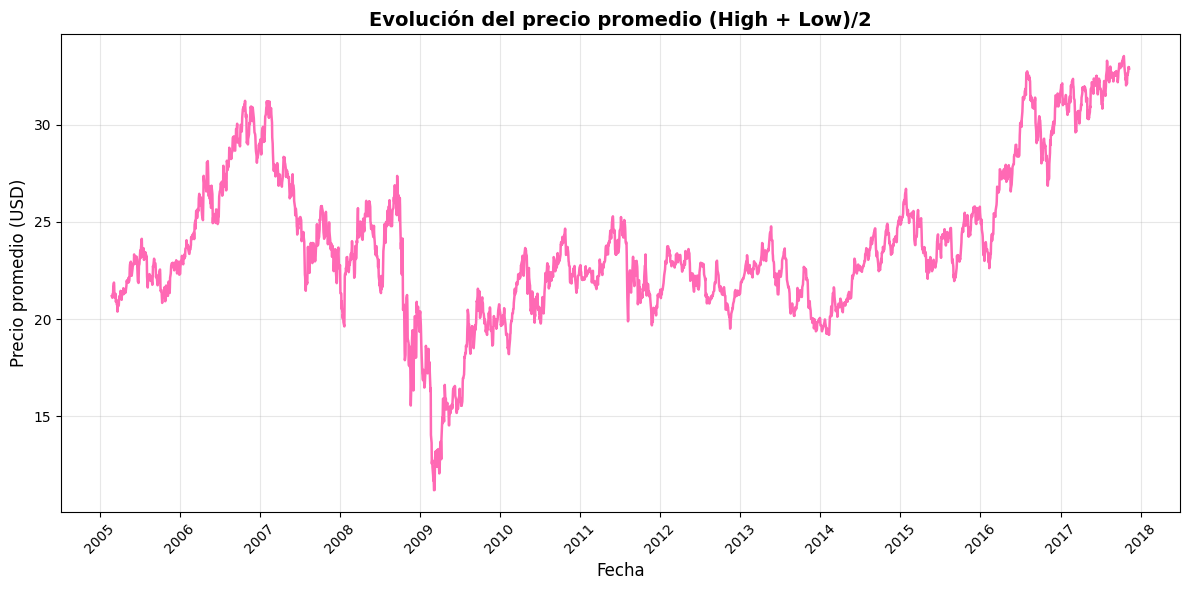

In [195]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convertir la columna 'Date' a formato de fecha
df["Date"] = pd.to_datetime(df["Date"])

plt.figure(figsize=(12,6))
plt.plot(df["Date"], price, color='hotpink', linewidth=1.8)

# Título y etiquetas
plt.title("Evolución del precio promedio (High + Low)/2", fontsize=14, weight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio promedio (USD)", fontsize=12)

# Formato del eje X para fechas
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))       
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 

# Rotar etiquetas y ajustar estilo
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Normalization

In [196]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1600
num_val_samples: 800
num_test_samples: 801


In [197]:
print("¿Hay NaN en raw_data?:", np.isnan(raw_data).any())
print("¿Hay inf en raw_data?:", np.isinf(raw_data).any())
std = raw_data[:num_train_samples].std(axis=0)
print("Mínimo std:", np.min(std))

¿Hay NaN en raw_data?: False
¿Hay inf en raw_data?: False
Mínimo std: 0.0


In [198]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)

# Verificar columnas con std = 0
constant_cols = np.where(std == 0)[0]
column_names = df.columns[1:]
print("Columnas constantes:", column_names[constant_cols])
print("Número de columnas constantes:", len(constant_cols))

std[std == 0] = 1 
raw_data /= std


Columnas constantes: Index(['OpenInt'], dtype='object')
Número de columnas constantes: 1


In [199]:
import numpy as np
from tensorflow import keras
from keras import layers

In [200]:


sequence_length = 30  
sampling_rate = 1    
delay = 1             
batch_size = 32

# Dataset de entrenamiento
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=price[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

# Dataset de validación
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=price[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

# Dataset de prueba
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=price[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)


In [201]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (32, 30, 6)
targets shape: (32,)


# Punto 2

## Funciones de graficas

In [202]:
import matplotlib.pyplot as plt

def graph_history(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "lightpink", label="Training MAE")
    plt.plot(epochs, val_loss, "purple", label="Validation MAE")
    plt.title("Training and validation MAE (LSTM)")
    plt.legend()
    plt.show()
    
def graph_prediction(y_true, predictions):
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(y_true[20:40], label='True Values', color='pink')
    plt.plot(predictions[20:40], label='Predicted Values', color='purple')
    plt.title('LSTM Predictions vs True Values')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


In [203]:
use_recurrent_dropout = True
dropout_rate = 0.2 

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16,  recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("wre.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("wre.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 519.6907 - mae: 22.5315 - val_loss: 453.4608 - val_mae: 21.2688
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 456.0687 - mae: 21.1016 - val_loss: 351.4301 - val_mae: 18.7130
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 381.3462 - mae: 19.2202 - val_loss: 289.2094 - val_mae: 16.9639
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 323.3953 - mae: 17.6275 - val_loss: 246.8993 - val_mae: 15.6667
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 278.8777 - mae: 16.2904 - val_loss: 211.8090 - val_mae: 14.5040
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 241.8016 - mae: 15.0924 - val_loss: 182.3274 - val_mae: 13.4486
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 211.7625 - mae: 14.0538 - val_loss: 157.7388 - val_mae: 12.5010
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 186.4037 - mae: 13.1174 - val_loss: 136.3196 - val_mae: 11.6127
Epoch 9/50
50/50

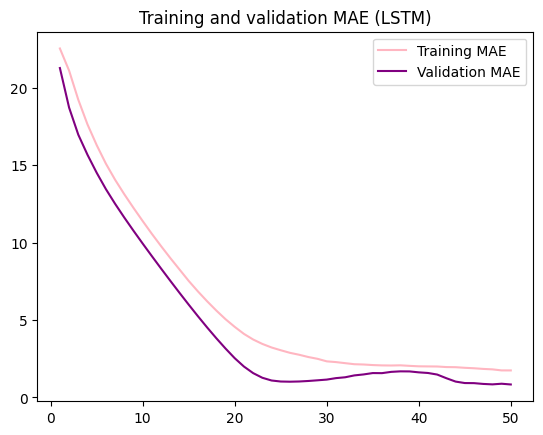

In [204]:
graficar_history(history)

## Prediction 


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


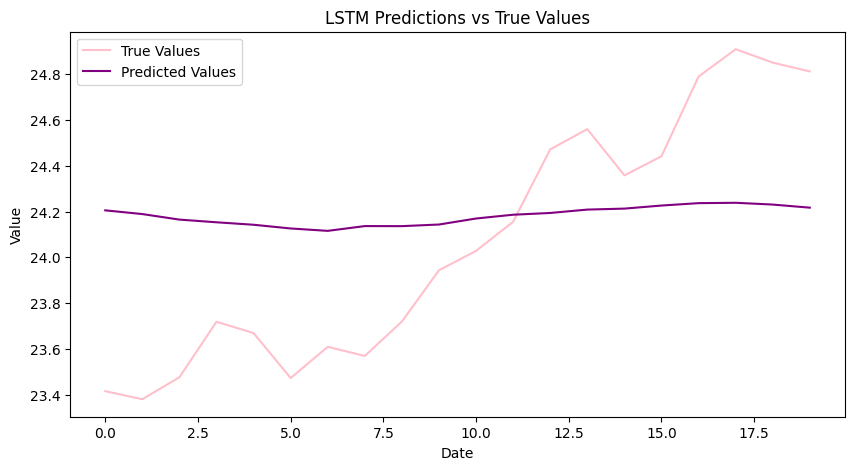

In [205]:
# Extraer valores verdaderos del test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
# Predicciones
predictions = model.predict(test_dataset)
# Graficar
graph_prediction(y_true, predictions)

# Punto 3

In [206]:
import tensorflow as tf

In [207]:
use_recurrent_dropout = True
dropout_rate = 0.2 

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16,  recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
outputs = layers.Dense(1)(x)
model1 = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("wreGRU.keras",
                                    save_best_only=True)
]
model1.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1 = model1.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model1 = keras.models.load_model("wreGRU.keras")
print(f"Test MAE: {model1.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 523.1035 - mae: 22.5940 - val_loss: 446.7878 - val_mae: 21.1017
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 485.0068 - mae: 21.7672 - val_loss: 386.0034 - val_mae: 19.6112
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 394.5845 - mae: 19.5961 - val_loss: 283.4400 - val_mae: 16.7955
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 324.2565 - mae: 17.7071 - val_loss: 241.8448 - val_mae: 15.5057
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 278.8840 - mae: 16.3427 - val_loss: 212.9650 - val_mae: 14.5436
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 245.8395 - mae: 15.2427 - val_loss: 188.2687 - val_mae: 13.6678
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 219.1247 - mae: 14.3191 - val_loss: 165.9279 - val_mae: 12.8244
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 195.2900 - mae: 13.4520 - val_loss: 145.3797 - val_mae: 11.9965
Epoch 9/50
50/50

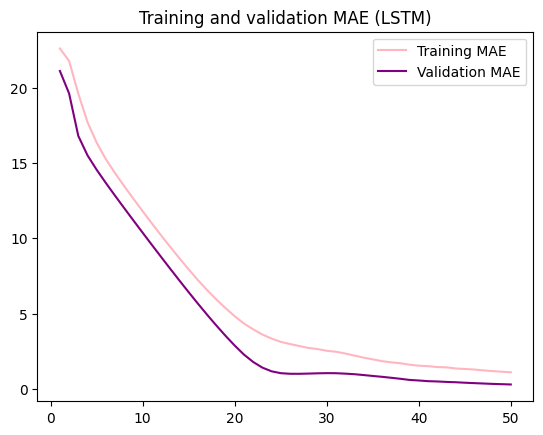

In [208]:
graph_history(history1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


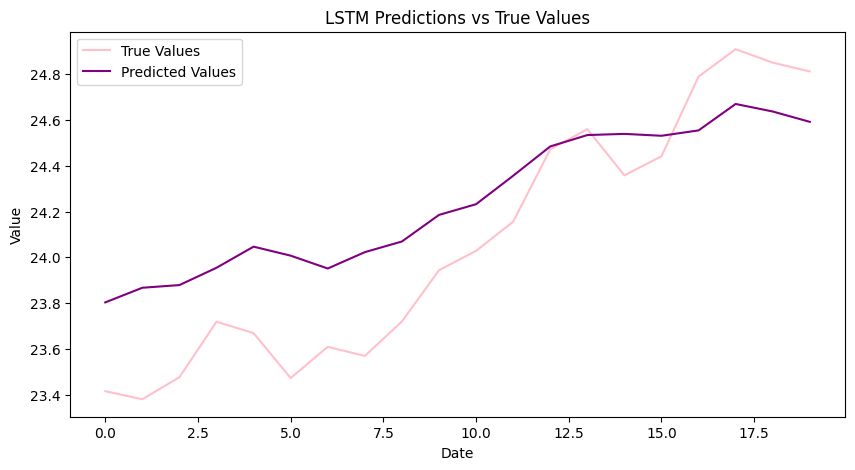

In [209]:
# Extraer valores verdaderos del test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
# Predicciones
predictions1 = model1.predict(test_dataset)
# Graficar
graph_prediction(y_true, predictions1)

# Punto 4

In [210]:
import tensorflow as tf

In [211]:
num_features = raw_data.shape[-1]
num_units_l1 = 64
num_units_l2 = 32
output_dim = 1

model3 = tf.keras.Sequential([
    tf.keras.layers.GRU(num_units_l1, return_sequences=True, input_shape=(sequence_length, num_features)),
    tf.keras.layers.GRU(num_units_l2, return_sequences=False),
    tf.keras.layers.Dense(output_dim, activation='linear')
])

callbacks = [
    keras.callbacks.ModelCheckpoint("stackedGRU.keras", save_best_only=True)
]

model3.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history3 = model3.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model2 = keras.models.load_model("stackedGRU.keras")




Epoch 1/50


c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 351.1659 - mae: 18.2542 - val_loss: 195.6364 - val_mae: 13.9345
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 225.2762 - mae: 14.4160 - val_loss: 152.8698 - val_mae: 12.3046
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 178.1070 - mae: 12.6759 - val_loss: 116.5825 - val_mae: 10.7293
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 136.5029 - mae: 11.0080 - val_loss: 85.7508 - val_mae: 9.1807
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 104.0960 - mae: 9.4779 - val_loss: 60.2362 - val_mae: 7.6662
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 77.9226 - mae: 8.0441 - val_loss: 39.8306 - val_mae: 6.1940
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 56.8736 - mae: 6.7336 - val_loss: 24.3577 - val_mae: 4.7846
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 40.7057 - mae: 5.5576 - val_loss: 13.4494 - val_mae: 3.4618
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55m

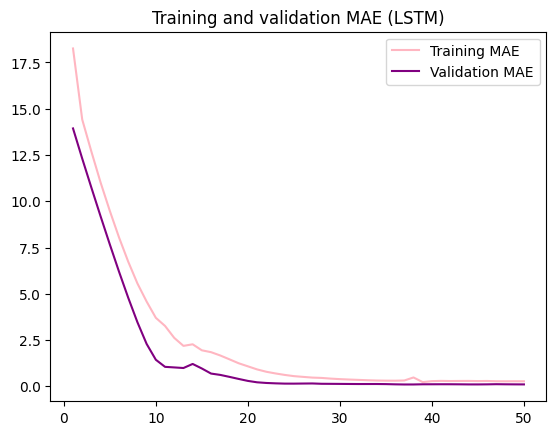

In [212]:
graph_history(history3)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


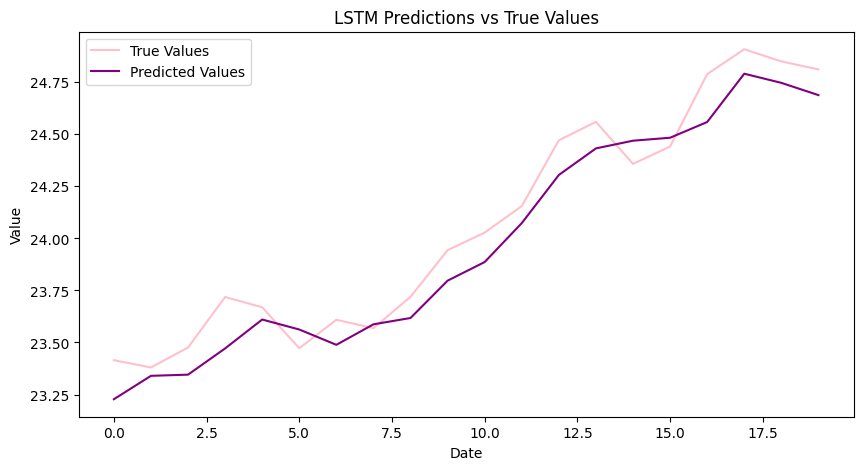

In [213]:
# Extraer valores verdaderos del test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
# Predicciones
predictions2 = model2.predict(test_dataset)
# Graficar
graph_prediction(y_true, predictions2)